In [35]:
library(dplyr)
library(ggplot2)

In [36]:
setwd("/ai/data/wuqiao/clinical_sample/WES/RAW_VCF/MT_analysis_2025.5.14_adjust_annotation/paired code and results_adjusted")

In [ ]:
mutation=read.table("data/190 samples adjacent tumor paired exon mutation.csv",sep=",",quote = "\"",header=T)

In [38]:
print(head(mutation))

       ID        Sample class  Chr Start   End Ref Alt Alt_all
1 1276016     KY-131795 tumor chrM 13262 13262   A   G       G
2 1276016     KY-131795 tumor chrM   530   530   C   T       T
3 1276016     KY-131795 tumor chrM   530   530   C   T       T
4 1276016     KY-131795 tumor chrM  8027  8027   G   A       A
5 1286797 KY-WES-137066 tumor chrM 11166 11166   G   A       A
6 1286797 KY-WES-137066 tumor chrM  2371  2371   T   C       C
             Mutation.Class Func.MT_ensGene Gene.MT_ensGene
1 Substitution (Transition)          exonic             ND5
2 Substitution (Transition)        upstream            RNR1
3 Substitution (Transition)        upstream        tRNA-Phe
4 Substitution (Transition)          exonic            COX2
5 Substitution (Transition)          exonic             ND4
6 Substitution (Transition)    ncRNA_exonic            RNR2
  ExonicFunc.MT_ensGene                        AAChange.MT_ensGene
1     nonsynonymous SNV  ND5:ENST00000361567:exon1:c.C925G:p.Q309E
2    

In [39]:
# Step 1: 计算每个基因在每个样本中的突变数目
mutation_counts <- mutation %>%
    filter(Gene.MT_ensGene != "missing") %>%  # 去掉 Gene.MT_ensGene 为 "missing" 的行
    group_by(Sample, Gene.MT_ensGene, class) %>%
    summarise(count = n(), .groups = 'drop')

In [41]:
print(head(mutation_counts))

# A tibble: 6 × 4
  Sample    Gene.MT_ensGene class    count
  <chr>     <chr>           <chr>    <int>
1 KY-131728 RNR1            adjacent     1
2 KY-131728 tRNA-Phe        adjacent     1
3 KY-131729 ND6             tumor        2
4 KY-131732 CYTB            adjacent    10
5 KY-131732 RNR1            adjacent     4
6 KY-131732 tRNA-Phe        adjacent     4


In [42]:
# Step 2:为每个基因在不同类别中计算平均突变数和95%置信区间
summary_stats <- mutation_counts %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(count),
        ci_lower = avg_count - 1.96 * sd(count) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(count) / sqrt(n()),
        .groups = 'drop'
    )

In [43]:
# Step 3: 构建所有基因与 class 的组合，保留并集
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(mutation_counts$Gene.MT_ensGene[mutation_counts$Gene.MT_ensGene != "missing"]),
  class = unique(mutation_counts$class),
  stringsAsFactors = FALSE
)

# Step 4: 合并后缺失处为 NA
summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [44]:
print(summary_stats_complete)

   Gene.MT_ensGene    class avg_count   ci_lower ci_upper
1             RNR1 adjacent  2.723077  2.0579812 3.388173
2         tRNA-Phe adjacent  2.741935  2.0496154 3.434256
3              ND6 adjacent  2.000000  2.0000000 2.000000
4             CYTB adjacent  5.318182  4.1128292 6.523534
5         tRNA-Pro adjacent  5.589744  4.3578544 6.821633
6         tRNA-Thr adjacent  5.500000  4.2683590 6.731641
7              ND5 adjacent  1.250000  0.9292197 1.570780
8              ND2 adjacent  3.125000  1.8186980 4.431302
9              ND3 adjacent  1.833333  0.8979024 2.768764
10        tRNA-Trp adjacent  3.500000  2.5200000 4.480000
11        tRNA-Val adjacent        NA         NA       NA
12             ND1 adjacent  1.000000  1.0000000 1.000000
13             ND4 adjacent  1.250000  0.7600000 1.740000
14       tRNA-Leu2 adjacent        NA         NA       NA
15            COX2 adjacent  2.500000  1.5200000 3.480000
16            ATP6 adjacent  1.363636  0.9652097 1.762063
17            

In [46]:
write.table(summary_stats_complete,"data/mean mutation counts of each gene in each sample_allgene.csv",sep=",",quote=F,row.names=F)

In [50]:
# 分别绘制 adjacent 类别的分布图
adjacent_stats <- summary_stats_complete %>% filter(class == "adjacent")

# 按照 avg_count 从大到小排序
adjacent_stats <- adjacent_stats %>%
  arrange(is.na(avg_count), desc(avg_count)) %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = Gene.MT_ensGene))

In [51]:
print(adjacent_stats)

   Gene.MT_ensGene    class avg_count  ci_lower ci_upper
1         tRNA-Pro adjacent  5.589744 4.3578544 6.821633
2         tRNA-Thr adjacent  5.500000 4.2683590 6.731641
3             CYTB adjacent  5.318182 4.1128292 6.523534
4             COX1 adjacent  5.125000 1.4687143 8.781286
5         tRNA-Trp adjacent  3.500000 2.5200000 4.480000
6         tRNA-Ala adjacent  3.500000 2.5200000 4.480000
7         tRNA-Asn adjacent  3.500000 2.5200000 4.480000
8         tRNA-Cys adjacent  3.500000 2.5200000 4.480000
9         tRNA-Tyr adjacent  3.500000 2.5200000 4.480000
10             ND2 adjacent  3.125000 1.8186980 4.431302
11        tRNA-Phe adjacent  2.741935 2.0496154 3.434256
12            RNR1 adjacent  2.723077 2.0579812 3.388173
13            COX2 adjacent  2.500000 1.5200000 3.480000
14             ND6 adjacent  2.000000 2.0000000 2.000000
15       tRNA-Ser1 adjacent  2.000000 2.0000000 2.000000
16            ATP8 adjacent  2.000000 0.8683935 3.131607
17        tRNA-Asp adjacent  2.

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


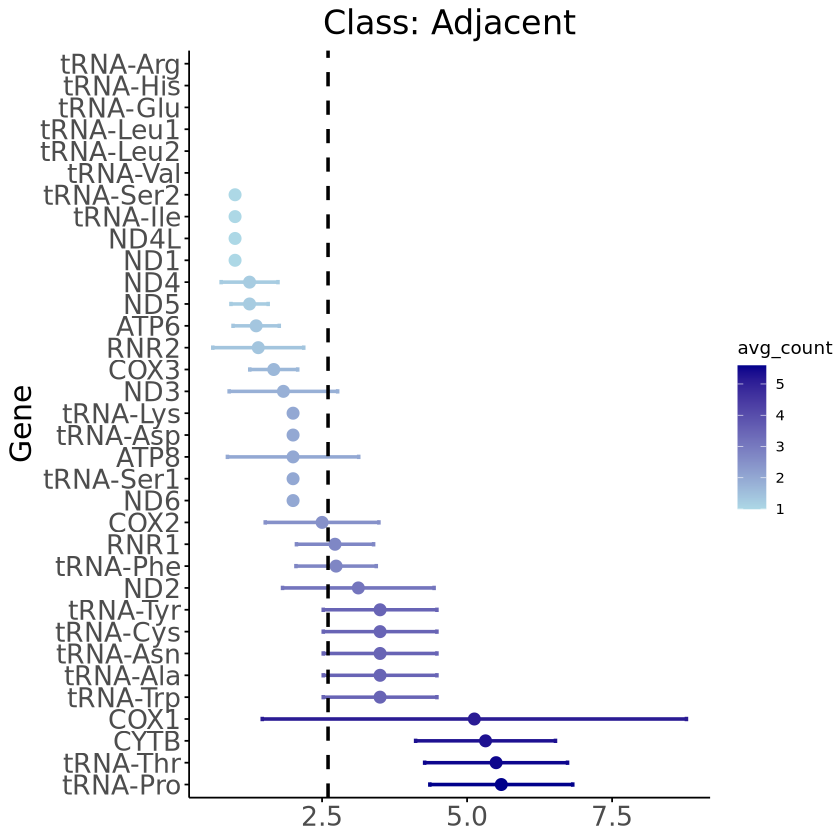

In [56]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue") +
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(adjacent_plot)

In [53]:
# 处理 tumor 类别的图
tumor_stats <- summary_stats_complete %>% filter(class == "tumor")

# 确保基因的顺序与 adjacent一致
tumor_stats <- tumor_stats %>%
    mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = levels(adjacent_stats$Gene.MT_ensGene)))

In [57]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue") +
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题



Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


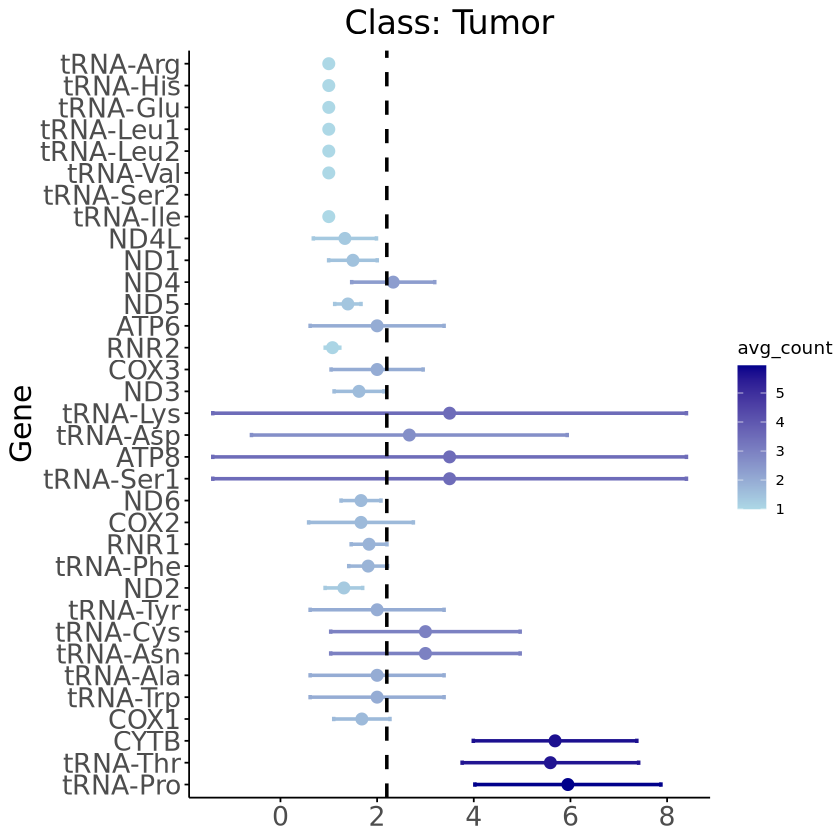

In [58]:
print(tumor_plot)

In [59]:
library(patchwork)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


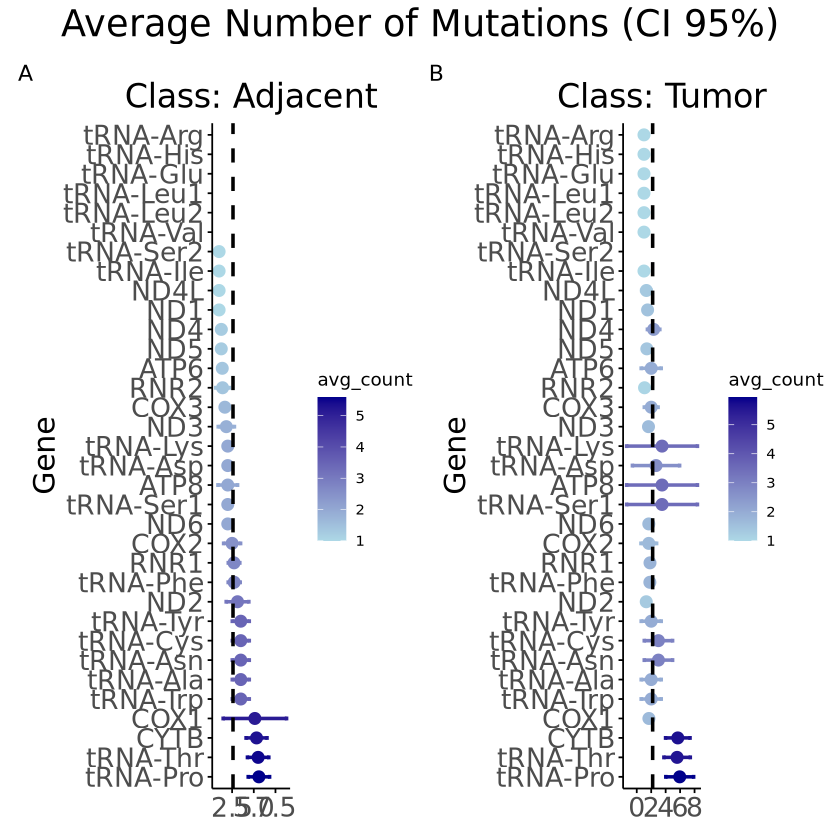

In [60]:

# 将两个图拼在一起，设置为一行
combined_plot <- (adjacent_plot | tumor_plot) +
    plot_layout(ncol = 2) +
    plot_annotation(title = "Average Number of Mutations (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))

# 添加一个共享的 X 轴标题
combined_plot <- combined_plot + 
    plot_annotation(tag_levels = 'A') +
    plot_layout(heights = c(1, 0)) +  # 调整高度
    labs(x = "Average Number of Mutations (CI 95%)")

print(combined_plot)

In [61]:
ggsave("plots/mutation count of per gene in one class all gene.pdf", plot = combined_plot, width = 14, height = 10,dpi=300)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
